# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Name: Melissa Sanchez

I understand that my submission needs to be my own work: Yes

Points: 10


---



## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [ ]:
'''
initial state: a board with 6 rows and 7 columns with no disks
actions: players can
          1) select a disk of thier color and drop it along the columns
          2) play a mean move: select a botton row disk from the opponent and place it back in the top of the same column
          3) a mean move can't be played if the opponent just played one
transition model:
                  1) switch player's turns
                  2) update the board by the current player move
                  3) update a flag to indicate if a mean move was played
                  4) check the board for a win or draw
test for the terminal state: a player as
                              1) check the board for a winner: form a 4-line vertical, horizontal, or diagonal of the same color disk
                              2) board has been compleated: no more disks can be added
utility for terminal states:
                            1) o for a tie
                            2) 1 for a win by the player
                            3) -1 for a win by the opponent
'''

How big is the state space? Give an estimate and explain it.

In [ ]:
'''
standard connect-4 has a spece of 3(tie, p1,p2) ** (7 * 6)= 3 ** 42, however in the addition of the mean move
the space is larger compared to the standard connect-4. However the legal posiiton of both the standard game
and modified are the same
'''

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [ ]:
'''
the game tree is all posible moves that can be made by one player. Each player can place a disk in one of the each column (7) plus
if a mean move is allowed it could be 7 more posible places, 14 per turn.
Each game could take up to 42 moves (to filled the whole board).
On the worse case the tree can go up to 14 ** 42 nodes
'''

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

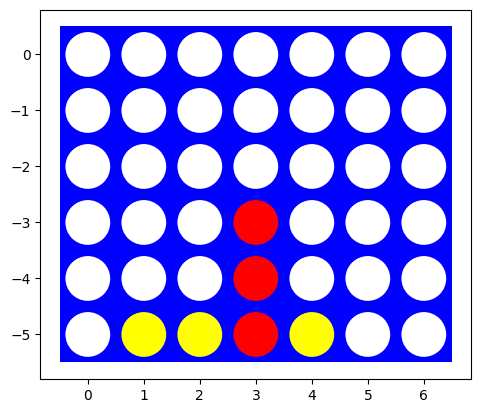

In [11]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
import random
def check_board(board, player, connect=4):
  row, column = board.shape
  #horizontal
  for r in range(row):
    for c in range(column - connect + 1):
      if np.all(board[r,c : c + connect] == player):
        return True
  #vertical
  for c in range(column):
    for r in range(row - connect + 1):
      if np.all(board[r: r + connect, c] == player):
        return True
  #diagonal /
  #reduced the grid from row and column up to possible moves up to connect on the lower left corner
  for r in range(connect - 1, row):
    for c in range(column - connect + 1):
      if np.all(np.array([board[r - i , c + i] for i in range(connect)]) == player):
        return True

  #diagonal \
  #reduced the grid from row and column up to possible moves up to connect on the upper left corner
  for r in range(row - connect + 1):
    for c in range(column - connect + 1):
      if np.all(np.array([board[r + i , c + i] for i in range(connect)]) == player):
        return True

  return False


def utility(state): #determinate a winnder or tie
  board, mean_flag, player = state

  #check if current player is a winner
  current_player_result = check_board(board, player)
  opponent_player_result = check_board(board, -player)

  if current_player_result and opponent_player_result:
    return 0 #tie
  elif current_player_result:
    return player
  elif opponent_player_result:
    return -player
  else:
    return 0 #board is full

def terminal(state): #check for a winner
  board, mean_flag, player = state

  #check if the game has terminated (any player has a connect or board is full)
  current_player_result = check_board(board, player)
  opponent_player_result = check_board(board, -player)
  if current_player_result or opponent_player_result or not (board == 0).any():
    return True
  return False

def actions(state): #actions
  #return all posible actions based on the board's state
  # actions are a tuple (move_type, c) move type is either standard or mean in which column
  #standard move is posible at any column that is not full
  #mean move is posible if 1) mean_flag is not set and 2) there is an opponent disk in the bottom row
  board, mean_flag  , player= state
  row, column = board.shape

  moves = []

  #standard moves
  for c in range(column):
    if board[0, c] == 0:
      moves.append(('standard', c ))

  #mean moves
  if not mean_flag:
    for c in range(column):
      if board[row - 1, c] == (-1 * player):
        moves.append(('mean', c))

  return moves

def result_state(state, action): #transitional model
  board, mean_flag , player = state
  row, column = board.shape
  new_board = board.copy()
  move_type, c = action

  #play a move by the current player
  #update mean_flag is mean move was played

  if move_type == 'standard':
    #drop a disk
    for r in range(row - 1, -1, -1):
      if new_board[r, c] == 0:
        new_board[r,c] = player
        break
    #update state
    new_state = (new_board, False, -player)

  elif move_type == 'mean' and new_board[row -1, c] == -player:#play a mean move

    #shift by 1
    for r in range(row - 1, 0, -1):
      new_board[r,c] = new_board[r-1,c]

    #add the opponent player disk on top
    placed = False
    for r in range(row):
      if new_board[r,c] == 0:
        new_board[r,c] = -player
        placed = True
        break
    #overide the top cell
    if not placed:
      new_board[0,c] = -player
    new_state = (new_board, True, -player)
  else:
    new_state = (new_board, mean_flag, -player)
  return new_state



Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [4]:
def random_player(state, player=None):
  if player is not None:
      board, mean_flag, _ = state
      state = (board, mean_flag, player)

  legal_moves = actions(state)

  if not legal_moves:
    return None

  return random.choice(legal_moves)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [12]:
def start_game(random_player, row, column):

  board = empty_board((row, column))

  state = (board, False, 1 )

  #play until the terimal state
  while not terminal(state):
    current_player = state[2]

    action = random_player(state, current_player)

    if action is None:
      break

    state = result_state(state, action)
  return utility(state)

games = 1000
r, c = 6,7
results = {1: 0, -1: 0, 0: 0}
for _ in range(games):
  winner = start_game(random_player, r, c)
  results[winner]+=1

print(f'For {games} games')
print(f'player 1:  won {results[1]} times')
print(f'player -1: won {results[-1]} times')
print(f'player resulted in at tie:  {results[0]} times')



For 1000 games
player 1:  won 470 times
player -1: won 285 times
player resulted in at tie:  245 times


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [5]:


def min_max_value(state, alpha, beta, depth, max_player):
  #alpha: best exlpored option for the minimizer
  #beta: best explored option for the maximizer
  #depth: search depth
  #max_player: original player maximizer
  board, mean_flag, player = state

  #if the game is over of depth is 0
  if terminal(state) or depth == 0:
    return utility(state)

  #maximizing player (original player)
  if state[2] == max_player:
    value = float('-inf')
    for action in actions(state):
      child_state = result_state(state, action)
      value = max(value, min_max_value(child_state, alpha, beta, depth - 1, max_player))
      alpha = max(alpha, value)
      if alpha >= beta:
        break
    return value
  #minimzing player (opponent player)
  else:
    value = float('inf')
    for action in actions(state):
      child_state = result_state(state, action)
      value = min(value, min_max_value(child_state, alpha, beta, depth - 1, max_player))
      alpha = min(beta, value)
      if beta <= alpha:
        break
    return value

def min_max_agent(state, player=None, depth_limit=4):
  if player is None:
    board, mean_flag, _ = state
    state = (board, mean_flag, player)

  max_player = state[2]
  best_action = None
  best_value = float('-inf')

  for action in actions(state):
    child_state = result_state(state, action)
    value = min_max_value(child_state, float('-inf'), float('inf'), depth_limit - 1, max_player)

    if value > best_value:
      best_value = value
      best_action = action
  return best_action

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [6]:
import time
import pandas as pd
def winning_board(row, col, player):
  board = empty_board((row, col))
  if col >4:
    board[row -1 : col - 1] = player
  return board


times = []
legal_moves =[]
diamentions =[]
for c in [4,5,6,7,8]:
  board = winning_board(6, c, player=1)
  state = (board, False, 1)
  start = time.time()
  move = min_max_agent(state, player=1, depth_limit=4)
  end = time.time() - start

  times.append(end)
  legal_moves.append(move)
  diamentions.append((6,c))

data = {
  '(r,c)': diamentions,
  'move selected': legal_moves,
  'time (s)': times
}
df = pd.DataFrame.from_dict(data)
print(df)


    (r,c)  move selected  time (s)
0  (6, 4)  (standard, 0)  0.641659
1  (6, 5)  (standard, 0)  1.170766
2  (6, 6)  (standard, 0)  3.882929
3  (6, 7)  (standard, 0)  0.013358
4  (6, 8)  (standard, 0)  0.018073


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [13]:
import time
import pandas as pd
def manual_boards(col):
  board = empty_board((6,col))
  board[5, :col -1 ] = 1
  return board

times = []
legal_moves =[]
diamentions =[]
for col in [4,5,6,7,8]:
  board = manual_boards(col)
  state = (board, False, 1)

  start = time.time()
  move = min_max_agent(state, player=1, depth_limit=4)
  end = time.time() - start

  times.append(end)
  legal_moves.append(move)
  diamentions.append((6,col))

data = {
'(r,c)': diamentions,
'move selected': legal_moves,
'time (s)': times
}
df = pd.DataFrame.from_dict(data)
print(df)


    (r,c)  move selected  time (s)
0  (6, 4)  (standard, 3)  0.310393
1  (6, 5)  (standard, 0)  0.003353
2  (6, 6)  (standard, 0)  0.006651
3  (6, 7)  (standard, 0)  0.008199
4  (6, 8)  (standard, 0)  0.014637


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

In [15]:
'''
by dropping disks in the center of the board the probablity of forming a 4-disk is greater.
1)prioritize the best move first (the center of the board)
2)organize legal moves by the distance to the center of the board
'''
import pandas as pd
def move_ordering(moves, board):
  rows, column = board.shape
  center = column // 2
  return sorted(moves, key=lambda x : abs(x[1] - center))

def min_max_agent_ordering(state, player=None, depth_limit=4):
  if player is None:
      board, mean_flag, _ = state
      state = (board, mean_flag, player)

  max_player = state[2]
  best_action = None
  best_value = float('-inf')
  ordering = move_ordering(actions(state), state[0])
  for action in ordering:
    child_state = result_state(state, action)
    value = min_max_value(child_state, float('-inf'), float('inf'), depth_limit - 1, max_player)

    if value > best_value:
      best_value = value
      best_action = action
  return best_action


def display_results():
  columns =[]
  ordering = []
  standard = []
  trials = 10
  for col in [4,5,6,7,8]:
    board = empty_board((6,col))
    state = (board, False, 1)

    time_standard =[]
    #standard min max agent
    for _ in range(trials):
      start = time.time()
      move = min_max_agent(state, player=1, depth_limit=4)
      end = time.time() - start
      time_standard.append(end)

    avg_time_standard = sum(time_standard) / len(time_standard)

    #ordering min max agent
    time_ordering = []
    for _ in range(trials):
      start = time.time()
      move = min_max_agent_ordering(state, player=1, depth_limit=4)
      end = time.time() - start
      time_ordering.append(end)

    avg_time_ordering = sum(time_ordering) / len(time_ordering)

    columns.append(col)
    standard.append(avg_time_standard)
    ordering.append(avg_time_ordering)

  data = {
        'number of columns': columns,
        'standard min max': standard,
        'move ordering': standard
    }
  df = pd.DataFrame.from_dict(data)
  print(df)
display_results()


   number of columns  standard min max  move ordering
0                  4          0.336823       0.336823
1                  5          1.311106       1.311106
2                  6          3.560985       3.560985
3                  7          7.779842       7.779842
4                  8         15.464889      15.464889


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
'''
worse-case: emtpy board

-> whenteh board is empty the branching is big since it needs to account for all posiblities and min max even with alpha-beta
    purining still needs to check all posiblities

what do to:
1) have a set of best initial moves such as moves in the center
2) be stratigic about steps, only allow moves that will benefic the player
3) use the best move first

'''

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [25]:


def play_time( board_shape=(4,4), depth_limit=4):
  board = empty_board(board_shape)
  state = (board, False, 1)

  while not terminal(state):
    current_player = state[2]

    if current_player == 1:
      move = min_max_agent(state, player=1, depth_limit=4)
    else:
      move = random_player(state, player=1)

    if move is None:
      break

    state = result_state(state, move)
  return utility(state)


games = 1000
results = {1: 0, -1: 0, 0: 0}
for _ in range(games):
  winner = play_time(board_shape=(4,4), depth_limit=4)
  results[winner]+=1

print(f'For {games} games')
print(f'player 1:  won {results[1]} times')
print(f'player -1: won {results[-1]} times')
print(f'player resulted in at tie:  {results[0]} times')

For 1000 games
player 1:  won 559 times
player -1: won 7 times
player resulted in at tie:  434 times


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [7]:
'''
1) make moves in the center of the board
2) avoid that the opponent wins (identify the potential connect-4)
3) try to add disks to places where winning is possible given the current board

heuristic function: get a score of of chances of winning : high (more likely to win ex: 3 of player's disk) to low (least likely to win or thread ex: opponent 3 disks)
'''

def get_score(window_space, player, connect=4):
  score= 0

  #advanatege
  # 4 in a row
  if window_space.count(player) == connect:
    return 100
  # 3 in a row but space for one
  elif window_space.count(player) == connect - 1 and window_space.count(0) == 1:
    score+=70
  #2 in a row but space for two
  elif window_space.count(player) == connect - 2 and window_space.count(0) == 2:
    score+=50


  #opponent thread
  if window_space.count(-player) == connect - 1 and window_space.count(0) == 1:
    score-=55
  elif window_space.count(-player) == connect - 2 and window_space.count(0) == 2:
    score-=25
  return score

def heuristic(state, connect=4):

  board, mean_flag, player = state
  rows, columns = board.shape
  score = 0

  #advantage moves in the center
  center = columns // 2
  center_pos = list(board[:, center])
  center_player_disk = center_pos.count(player)
  score += center_player_disk * 2

  #horizontal
  for r in range(rows):
    for c in range(columns - connect + 1):
      window_space = list(board[r, c : c+ connect])
      score += get_score(window_space, player)
  #vertical
  for c in range(columns):
    for r in range(rows - connect + 1):
      window_space = list(board[r : r+ connect, c])
      score += get_score(window_space, player)
  #diagonal \
  for r in range(connect - 1, rows):
    for c in range(columns - connect + 1):
      window_space = list([board[r - i, c + i] for i in range(connect)])
  #diagonal /
  for r in range(rows - connect + 1):
    for c in range(columns - connect + 1):
      window_space = list([board[r + i, c + i] for i in range(connect)])
  score = max(min(score, 100), -100)
  return score


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [10]:
import time

def min_max_value_heuristic(state, alpha, beta, depth, max_player):
  #alpha: best exlpored option for the minimizer
  #beta: best explored option for the maximizer
  #depth: search depth
  #max_player: original player maximizer
  board, mean_flag, player = state

  #if the game is over of depth is 0
  if terminal(state) or depth == 0:
    return heuristic(state)

  #maximizing player (original player)
  if state[2] == max_player:
    value = float('-inf')
    for action in actions(state):
      child_state = result_state(state, action)
      value = max(value, min_max_value_heuristic(child_state, alpha, beta, depth - 1, max_player))
      alpha = max(alpha, value)
      if alpha >= beta:
        break
    return value
  #minimzing player (opponent player)
  else:
    value = float('inf')
    for action in actions(state):
      child_state = result_state(state, action)
      value = min(value, min_max_value_heuristic(child_state, alpha, beta, depth - 1, max_player))
      alpha = min(beta, value)
      if beta <= alpha:
        break
    return value
def min_max_agent_heuristic(state, player=None, depth_limit=4):
  if player is None:
    board, mean_flag, _ = state
    state = (board, mean_flag, player)

  max_player = state[2]
  best_action = None
  best_value = float('-inf')

  for action in actions(state):
    child_state = result_state(state, action)
    value = min_max_value_heuristic(child_state, float('-inf'), float('inf'), depth_limit - 1, max_player)

    if value > best_value:
      best_value = value
      best_action = action
  return best_action
def play_time_heuristic( board_shape=(4,4), depth_limit=4):
  board = empty_board(board_shape)
  state = (board, False, 1)

  while not terminal(state):
    current_player = state[2]

    if current_player == 1:
      move = min_max_agent_heuristic(state, player=1, depth_limit=4)
    else:
      move = random_player(state, player=1)

    if move is None:
      break

    state = result_state(state, move)
  return utility(state)


games = 10
results = {1: 0, -1: 0, 0: 0}

depths = []
total_time = 0
for depth in [2,3,4,5,6]:
  for _ in range(games):
    start = time.time()

    winner = play_time_heuristic(board_shape=(4,4), depth_limit=depth)
    results[winner]+=1
    total_time += time.time() - start


    depths.append(depth)



data = {
    'depth': depths,
    'wins': results[1],
    'losses': results[-1],
    'ties': results[0],
    'average time (s)': total_time / games
}
delattrf = pd.DataFrame.from_dict(data)
print(df)





    (r,c)  move selected  time (s)
0  (6, 4)  (standard, 0)  0.641659
1  (6, 5)  (standard, 0)  1.170766
2  (6, 6)  (standard, 0)  3.882929
3  (6, 7)  (standard, 0)  0.013358
4  (6, 8)  (standard, 0)  0.018073


Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [16]:
times = []
legal_moves =[]
diamentions =[]
for c in [4,5,6,7,8]:
  board = winning_board(6, c, player=1)
  state = (board, False, 1)
  start = time.time()
  move = min_max_agent_heuristic(state, player=1, depth_limit=4)
  end = time.time() - start

  times.append(end)
  legal_moves.append(move)
  diamentions.append((6,c))

data = {
  '(r,c)': diamentions,
  'move selected': legal_moves,
  'time (s)': times
}
df = pd.DataFrame.from_dict(data)
print(df)

    (r,c)  move selected  time (s)
0  (6, 4)  (standard, 2)  0.361115
1  (6, 5)  (standard, 2)  0.792177
2  (6, 6)  (standard, 2)  2.021097
3  (6, 7)  (standard, 0)  0.005434
4  (6, 8)  (standard, 0)  0.007448


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [17]:
times = []
legal_moves =[]
diamentions =[]
for c in [4,5,6,7,8,9,10]:
  board = empty_board((6,col))
  state = (board, False, 1)
  start = time.time()
  move = min_max_agent_heuristic(state, player=1, depth_limit=4)
  end = time.time() - start

  times.append(end)
  legal_moves.append(move)
  diamentions.append((6,c))

data = {
  '(r,c)': diamentions,
  'move selected': legal_moves,
  'time (s)': times
}
df = pd.DataFrame.from_dict(data)
print(df)

     (r,c)  move selected   time (s)
0   (6, 4)  (standard, 4)  10.051220
1   (6, 5)  (standard, 4)   8.868629
2   (6, 6)  (standard, 4)  10.081222
3   (6, 7)  (standard, 4)  10.178112
4   (6, 8)  (standard, 4)   9.615595
5   (6, 9)  (standard, 4)   9.251347
6  (6, 10)  (standard, 4)  10.176538


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [19]:
def display_results():
  columns =[]
  game_1 = []
  game_2 = []
  trials = 10
  for col in [4,5,6,7,8]:
    board = empty_board((6,col))
    state = (board, False, 1)

    time_game_1 =[]
    for _ in range(trials):
      start = time.time()
      move = min_max_agent_heuristic(state, player=1, depth_limit=4)
      end = time.time() - start
      time_game_1.append(end)

    avg_time_1 = sum(time_game_1) / len(time_game_1)

    #ordering min max agent
    time_game_2 = []
    for _ in range(trials):
      start = time.time()
      move = min_max_agent_heuristic(state, player=1, depth_limit=4)
      end = time.time() - start
      time_game_2.append(end)

    avg_time_2 = sum(time_game_2) / len(time_game_2)

    columns.append(col)
    game_1.append(avg_time_1)
    game_2.append(avg_time_2)

  data = {
        'number of columns': columns,
        'game 1': game_1,
        'game 2': game_2
    }
  df = pd.DataFrame.from_dict(data)
  print(df)
display_results()

   number of columns     game 1    game 2
0                  4   0.334993  0.233907
1                  5   0.846688  0.860843
2                  6   2.349667  2.360590
3                  7   4.910870  5.012482
4                  8  10.019488  9.800241


---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
